<ipython-input-11-75cb52099ac9>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[percentile_col_name] = df[feature].rank(pct=True)
<ipython-input-11-75cb52099ac9>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[percentile_col_name] = df[feature].rank(pct=True)
<ipython-input-11-75cb52099ac9>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

The most similar player to JJ McCarthy is Mitchell Trubisky with a similarity score of 0.96.


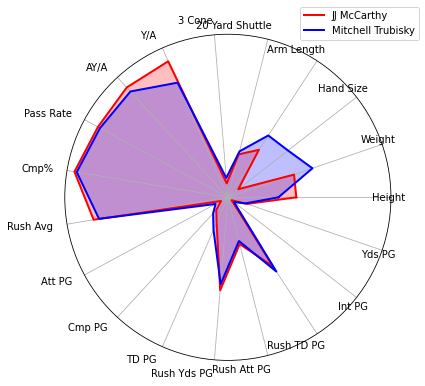

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load your data
data = pd.read_csv('C:/Users/RaymondCarpenter/Documents/GitHub/14thstreetanalytics/nfl-draft/qb_sheet.csv')

# Fields to normalize by 'games_played' and fields used directly
fields_to_normalize = [
    'Att', 'Cmp', 'TD', 'Rush Yds', 'Rush Att', 'Rush TD', 'Int', 'Yds'
]
fields_not_normalized = [
    'Height', 'Weight', 'Hand Size', 'Arm Length', '40 Yard Dash', 'Vertical', 'Broad Jump', '20 Yard Shuttle', '3 Cone', 
    'Y/A', 'AY/A', 'Pass Rate', 'Cmp%', 'Rush Avg'
]

# Convert all relevant fields to numeric, handling non-numeric entries
for field in fields_to_normalize + fields_not_normalized + ['GP']:
    data[field] = pd.to_numeric(data[field], errors='coerce')

# Normalize fields by games played
data = normalize_fields(data, fields_to_normalize)

# Find non-empty features for the player
player_name = input("Enter the name of the 2024 player to compare: ")
player_data = data[data['Draft Class'] == 2024]
player_row = player_data[player_data['Name'].str.lower() == player_name.lower()].iloc[0]

if player_row.empty:
    print("Player not found in the 2024 draft class. Please check the name and try again.")
else:
    non_empty_features = [field for field in fields_not_normalized if not pd.isna(player_row[field])]
    non_empty_features += [field + ' PG' for field in fields_to_normalize if not pd.isna(player_row[field + ' PG'])]

    # Filter out players missing any of these non-empty features
    data_filtered = data.dropna(subset=non_empty_features)

    # Calculate percentiles only for these features
    data_filtered = calculate_percentiles(data_filtered, non_empty_features)

    # Normalize the feature values using StandardScaler
    scaler = StandardScaler()
    data_filtered[non_empty_features] = scaler.fit_transform(data_filtered[non_empty_features])

    data_2024_scaled = data_filtered[data_filtered['Draft Class'] == 2024]
    data_not_2024_scaled = data_filtered[data_filtered['Draft Class'] != 2024]

    # Calculate cosine similarity
    similarity = cosine_similarity(data_2024_scaled[non_empty_features], data_not_2024_scaled[non_empty_features])
    player_index = data_2024_scaled.index.get_loc(player_row.name)  # Get location in filtered data
    similarity_scores = similarity[player_index]
    most_similar_index = similarity_scores.argmax()
    most_similar_player_name = data_not_2024_scaled.iloc[most_similar_index]['Name']
    
    print(f"The most similar player to {player_name} is {most_similar_player_name} with a similarity score of {similarity_scores[most_similar_index]:.2f}.")

    # Prepare data for the radar chart
    percentile_features = [f'{feature} Percentile' for feature in non_empty_features]
    player_percentiles = data_2024_scaled.loc[player_row.name, percentile_features]
    similar_player_percentiles = data_not_2024_scaled.iloc[most_similar_index][percentile_features]

    labels = np.array([feature.replace(' Percentile', '') for feature in percentile_features])
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1] 

    player_stats = player_percentiles.tolist() + player_percentiles.tolist()[:1]
    similar_player_stats = similar_player_percentiles.tolist() + similar_player_percentiles.tolist()[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, player_stats, color='red', alpha=0.25)
    ax.fill(angles, similar_player_stats, color='blue', alpha=0.25)
    ax.plot(angles, player_stats, color='red', linewidth=2, label=player_name)
    ax.plot(angles, similar_player_stats, color='blue', linewidth=2, label=most_similar_player_name)
    
    ax.set_xticks(angles[:-1])
    
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticks([])  # Removes radial gridlines

    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()


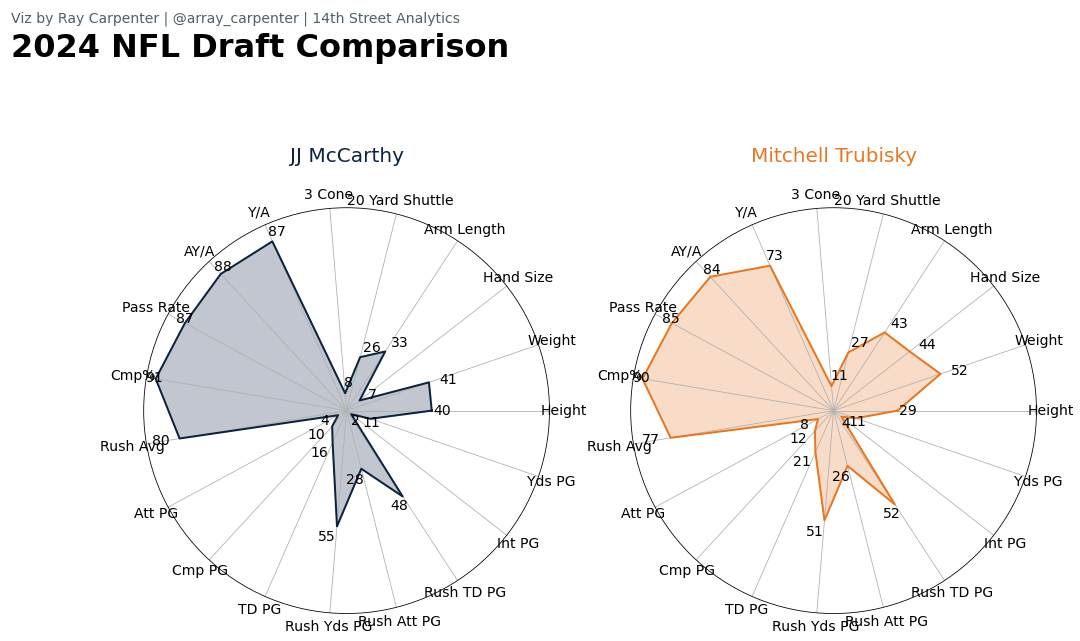

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from matplotlib.gridspec import GridSpec
from highlight_text import fig_text

def make_radar_chart(name, stats, feature_names, ax, fill_color, line_color):
    num_vars = len(feature_names)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    stats += stats[:1]
    angles += angles[:1]
    ax.fill(angles, stats, color=fill_color, alpha=0.25)
    ax.plot(angles, stats, color=line_color, linewidth=2)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_names, fontsize=14)
    ax.set_title(name, size=20, color=line_color, y=1.1)
    for label, angle, stat in zip(feature_names, angles[:-1], stats[:-1]):
        ha = 'center' if angle in (0, pi) else 'left' if 0 < angle < pi else 'right'
        ax.text(angle, stat + 0.05, f"{int(stat*100)}", size=14, horizontalalignment=ha, verticalalignment="center")
    ax.set_yticks([])

# Creating a figure with a custom layout using GridSpec.
fig = plt.figure(figsize=(16, 10), facecolor='white')
gs = GridSpec(5, 2, fig)

# Allocating specific axes for the radar charts.
ax1 = fig.add_subplot(gs[1:, 0], polar=True)
ax2 = fig.add_subplot(gs[1:, 1], polar=True)

# Use fig_text or plt.text to add text in the reserved area.
fig_text(
    x=0.01, y=0.95, 
    s="2024 NFL Draft Comparison",
    va="top", ha="left",
    fontsize=32, color="black", weight="bold",
    fig=fig
)
fig_text(
    x=0.01, y=.98, 
    s="Viz by Ray Carpenter | @array_carpenter | 14th Street Analytics",
    va="top", ha="left",
    fontsize=14, color="#4E616C",
    fig=fig
)

player_color = '#0C2340'
similar_player_color = '#E87722'


make_radar_chart(player_name, player_percentiles.tolist(), labels, ax1, fill_color=player_color, line_color=player_color)
make_radar_chart(most_similar_player_name, similar_player_percentiles.tolist(), labels, ax2, fill_color=similar_player_color, line_color=similar_player_color)

plt.show()